In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from myusefultools.pyopenfoam import OpenFOAM
from pathlib import Path
import multiprocessing as mp
import os
import itertools

# command = """ foamDictionary $(foamListTimes -latestTime)/h -entry boundaryField.top -set "{type uniformInletOutlet; value $internalField; uniformInletValue {type csvFile; nHeaderLine 1; refColumn 0; componentColumns (1); separator \",\"; mergeSeparators no; file \"../experimental-data/headFixed_SW150/headFixed_1.csv\";} }" """

In [2]:
## Check CASES folder exists
cases_folder = Path("CASES")
if not cases_folder.exists():
    os.mkdir(cases_folder)

template_folder = Path("template")

In [3]:
identifier = f"CASES/casetest"
of = OpenFOAM(
    path_case=identifier, write_to_log = True, path_template=template_folder
)


In [4]:
from dataclasses import dataclass

@dataclass(slots=True)
class unsatTime:
    initialTime: float
    finalTime: float
    initialHead: float
    finalHead: float

cycles = [
    unsatTime(41, 88, 0, 0.26),
    unsatTime(251, 287, 0, 0.26),
    unsatTime(461, 499, 0, 0.26),
    unsatTime(671, 708, 0, 0.26),
    unsatTime(880, 917, 0, 0.26),
    unsatTime(1089, 1125, 0, 0.26),
    unsatTime(1299, 1340, 0, 0.26),
    unsatTime(1509, 1546, 0, 0.26),
    unsatTime(1720, 1752, 0, 0.26),
]


In [5]:
# def set_boundary_csvFixedValue(self, csvfile):
#     with open(csvfile) as f:
#         _ = f.readline()
#         first_value = f.readline().split(",")[1]

#     ## Set fixedValue but reading from a CSV file
#     self.set_value_in_foamDictionary(
#         f"{self.latest_time}/h", 
#         entry="boundaryField.top",
#         value="""{type unsatTime; value """ + first_value + """; uniformValue csvFile; uniformValueCoeffs{nHeaderLine 1; refColumn 0; componentColumns (1); separator \",\"; mergeSeparators no; file \"../../""" + csvfile + """\";} }""")
#         # value="""{type uniformFixedValue; value <internalField>; uniformValue tableFile; uniformValueCoeffs{file \"""" + csvfile + """\";} }""")

    # with open(self.path_case/Path(self.latest_time, "h")) as f:
    #     input = f.read()
    #     edited = input.replace("<internalField>", "$internalField")

    # with open(self.path_case/Path(self.latest_time, "h"), "w") as f:  
    #     f.write(edited)

def set_boundary_unsatTime(self, cycle:unsatTime):
    t0 = cycle.initialTime * 60
    tf = cycle.finalTime * 60
    h0 = cycle.initialHead
    hf = cycle.finalHead

    ## Set fixedValue but reading from a CSV file
    self.set_value_in_foamDictionary(
        f"{self.latest_time}/h", 
        entry="boundaryField.top",
        value=f"""{{type unsatTime; value {h0}; initialTime {t0}; finalTime {tf}; initialHead {h0}; finalHead {hf}; }}""")
        
## Make that function a bounded method of the OpenFOAM class
setattr(OpenFOAM, set_boundary_unsatTime.__name__, set_boundary_unsatTime)

In [6]:
of.set_boundary_unsatTime(cycles[1])

In [7]:
cycle_times = [
    (41, 102, 173),   #(time_to_dry, time_to_flood_up, time_to_flood_down)
    (251, 311, 411), 
    (461 , 521, 617), 
    (671 , 732, 822), 
    (880 , 940, 1032), 
    (1089, 1179, 1243),
    (1299, 1359, 1448),
    (1509, 1569, 1659), 
    (1720, 1781, 1867),
    (2015, None, None)
]

for i, (bc, cycle) in enumerate(zip(cycles, cycle_times), start=1):
    ## Cycle 1
    ## Dry: set fixedGradient 
    
    dryt, floodt = cycle

    of.logger(f"\n🔥 ======= Cycle {i}")
    of.logger("\n🔥 ======= Dry period ======")
    if not dryt: break
    of.set_endtime(dryt)
    of.set_boundary_fixedGradient()
    of.set_convergeThreshold(0.250)
    of.cleanup_last_timestep()
    status = of.run_solver()
    of.logger(f"\nSolver ended with return code {status}")
    if status != 0: 
        print(f"Died while drying in cycle {i}", status, of.latest_time)
        break
    
    # if input("Continue?") == "NO":
    #     break

    # Flood: use meadured head
    of.logger("\n🌊 ====== Flood period ======")
    if not floodt: break

    of.set_endtime(floodt)
    of.set_boundary_unsatTime(bc)
    # headFixed_time = f"experimental-data/headFixed_SW150/headFixed_{i}.csv"
    # headFixed_time = "experimental-data/headFixed_SW150/dummy.csv"
    # of.set_boundary_csvFixedValue(headFixed_time)
    of.set_convergeThreshold(0.001)
    status = of.run_solver()
    of.logger(f"\nSolver ended with return code {status}")
    if status != 0: break

    if status != 0: 
        print(f"Died while flooding in cycle {i}", status, of.latest_time)
        break


In [8]:
print(of.latest_time, float(of.latest_time)/60, i)

106860.000 1781.0 9


In [9]:
of.foam_to_vtk()
of.boundaryProbes_to_txt()
of.process_boundaryProbes()

In [10]:
of.boundaryProbes[0].probes_points

[probePoint(x=0.1, y=0.1, z=6.0), probePoint(x=0.1, y=0.1, z=0.0)]

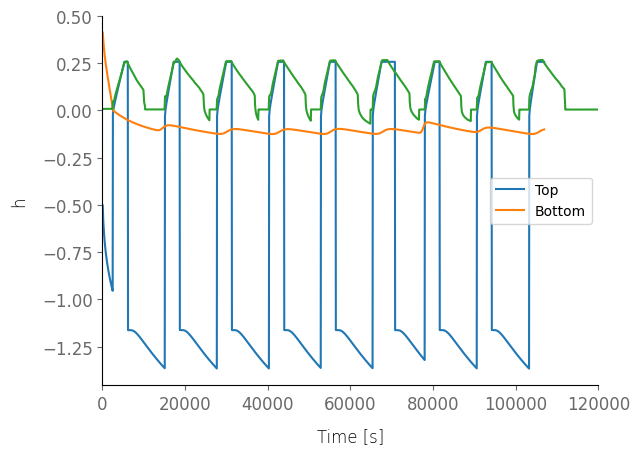

In [23]:
DIM = 0 # 0 for scalar, 1 for vector
FIELD = "h"

fig, ax = plt.subplots()
ax.plot(of.boundaryProbes[DIM].array_data.time, of.boundaryProbes[DIM].array_data[FIELD][0], label="Top")
ax.plot(of.boundaryProbes[DIM].array_data.time, of.boundaryProbes[DIM].array_data[FIELD][1], label="Bottom")
ax.legend()
ax.set_xlabel("Time [s]")
ax.set_ylabel(FIELD)
ax.plot(time_experimental, experimental["SH"]/100, label="Experimental")
ax.set_xlim(0,120_000)
plt.show()

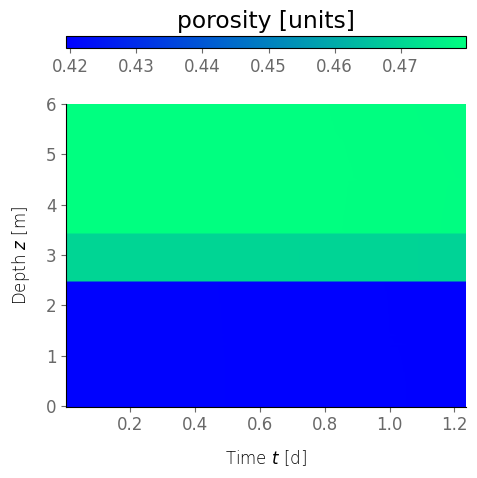

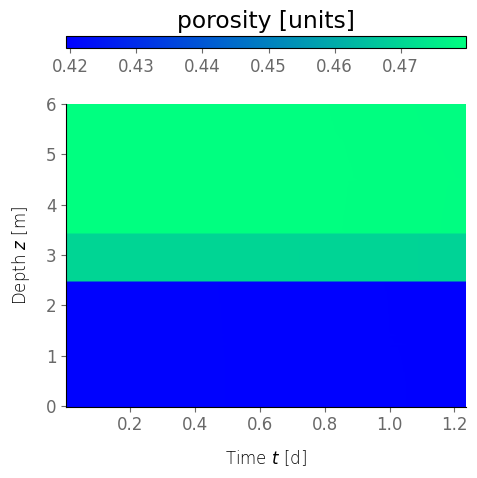

In [12]:
import json

field = "porosity"

with open("../Rosenzweig_2011/fit_ravid/heatmaps_config.json") as f:
    heatmaps_config = json.load(f)

default_pcolormesh_kwargs = dict(cmap="winter")
pcolormesh_kwargs = heatmaps_config.get(field) or default_pcolormesh_kwargs

of.plot_field_over_time(field, pcolormesh_kwargs)

In [13]:
sw = of.read_field_all_times("Sw")
porosity = of.read_field_all_times("porosity")

In [14]:
porosity

<xarray.DataArray (z: 301, t: 371)>
array([[0.47994   , 0.47993901, 0.47993901, ..., 0.47923401, 0.47922799,
        0.47922599],
       [0.47994   , 0.47993901, 0.47993901, ..., 0.47923604, 0.47922999,
        0.47922802],
       [0.47994   , 0.47993901, 0.47993901, ..., 0.47923851, 0.47923201,
        0.47923052],
       ...,
       [0.41993999, 0.41993901, 0.41993901, ..., 0.4194825 , 0.41948   ,
        0.41947901],
       [0.41993999, 0.41993901, 0.41993901, ..., 0.41948199, 0.41947949,
        0.41947901],
       [0.41993999, 0.41993901, 0.41993901, ..., 0.41948199, 0.41947901,
        0.41947901]])
Coordinates:
  * z        (z) float32 6.0 5.98 5.96 5.94 5.92 5.9 ... 0.08 0.06 0.04 0.02 0.0
  * t        (t) float64 301.8 601.8 901.8 ... 1.065e+05 1.068e+05 1.069e+05

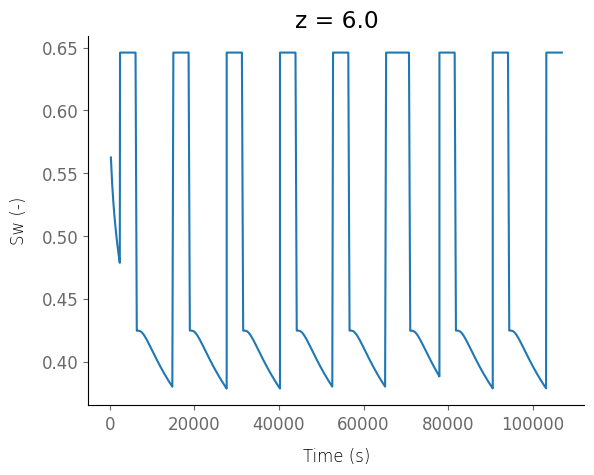

In [19]:
fig, ax = plt.subplots()
sw.sel(z=6.00).plot.line(x="t", ax=ax)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Sw (-)")
plt.show()

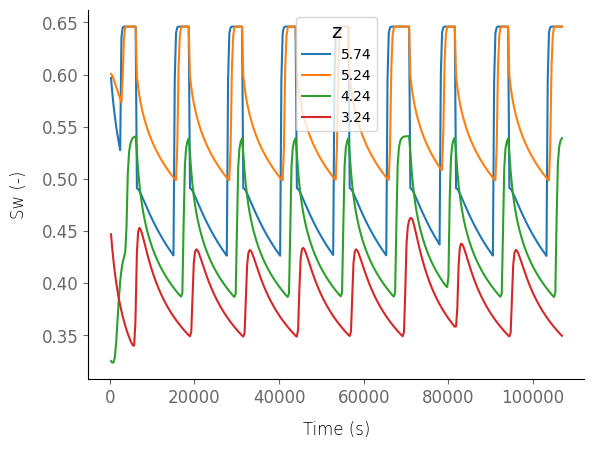

In [15]:
fig, ax = plt.subplots()
sw.sel(z=[5.74, 5.24, 4.24, 3.24]).plot.line(x="t", ax=ax)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Sw (-)")
plt.show()

In [16]:
experimental = pd.read_csv("./experimental-data/.hiddendata/Figure2.csv")
experimental

,SH,WC 25,OXY 25,WC 75,OXY 75,WC 175,OXY 175,WC 275,OXY 275
0,0.63,12.66,8.61,13.10,7.64,12.40,6.95,6.92,6.78
1,0.61,12.66,8.61,13.07,7.64,12.36,6.95,6.98,6.77
2,0.83,12.66,8.60,13.09,7.64,12.39,6.94,6.96,6.77
3,0.84,12.66,8.60,13.08,7.64,12.37,6.94,7.02,6.76
4,0.84,12.66,8.61,13.09,7.64,12.40,6.93,6.98,6.76
...,...,...,...,...,...,...,...,...,...
4506,-1.88,27.80,6.56,16.59,5.17,15.79,2.81,10.71,3.17
4507,-1.84,27.79,6.56,16.56,5.16,15.78,2.81,10.80,3.17
4508,-1.82,27.79,6.55,16.54,5.16,15.75,2.82,10.77,3.17
4509,-1.75,27.79,6.54,16.55,5.15,15.76,2.82,10.76,3.17


In [17]:
len(experimental)

4511

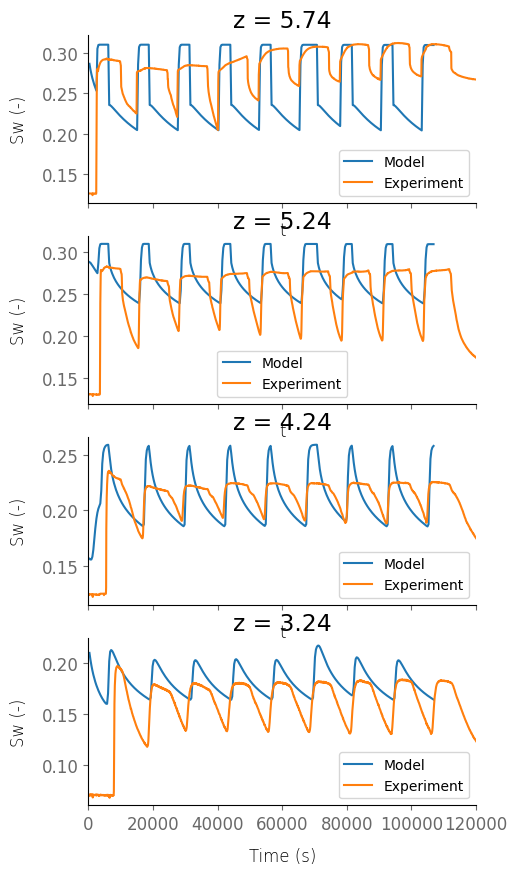

In [18]:
depths = [5.74, 5.24, 4.24, 3.24]
colnames = ["WC 25", "WC 75", "WC 175", "WC 275"]
fig, axs = plt.subplots(4,1, figsize=[5,10], sharex=True)

for d,c,ax in zip(depths, colnames, axs):
    theta = (sw*porosity).sel(z=d)
    theta.plot.line(x="t", ax=ax, label="Model")
    time_experimental = np.arange(len(experimental))*60 # Data acquisition every minute
    ax.plot(time_experimental, experimental[c]/100 , label="Experiment")
    ax.set_ylabel("Sw (-)")
    ax.set_xlim(0, 120_000)
    ax.legend()
ax.set_xlabel("Time (s)")
plt.show()